# Nearest neighbor for handwritten digit recognition

In this notebook we will build a classifier that takes an image of a handwritten digit and outputs a label 0-9. We will look at a particularly simple strategy for this problem known as the **nearest neighbor classifier**.

To run this notebook you should have the following Python packages installed:
* `numpy`
* `matplotlib`
* `sklearn`

## 1. The MNIST dataset

`MNIST` is a classic dataset in machine learning, consisting of 28x28 gray-scale images handwritten digits. The original training set contains 60,000 examples and the test set contains 10,000 examples. In this notebook we will be working with a subset of this data: a training set of 7,500 examples and a test set of 1,000 examples.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
!ls "/content/drive/MyDrive/Colab Notebooks/UCSanDiegoX DSE220x Machine Learning Fundamentals/NN_MNIST/MNIST"
local_folder = "/content/drive/MyDrive/Colab Notebooks/UCSanDiegoX DSE220x Machine Learning Fundamentals/NN_MNIST/MNIST/"

test_data.npy  test_labels.npy	train_data.npy	train_labels.npy


In [7]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import time

## Load the training set
train_data = np.load(f'{local_folder}train_data.npy')
train_labels = np.load(f'{local_folder}train_labels.npy')

## Load the testing set
test_data = np.load(f'{local_folder}test_data.npy')
test_labels = np.load(f'{local_folder}test_labels.npy')

In [ ]:
## Print out their dimensions
print("Training dataset dimensions: ", np.shape(train_data))
print("Number of training labels: ", len(train_labels))
print("Testing dataset dimensions: ", np.shape(test_data))
print("Number of testing labels: ", len(test_labels))

Training dataset dimensions:  (7500, 784)
Number of training labels:  7500
Testing dataset dimensions:  (1000, 784)
Number of testing labels:  1000


In [ ]:
## Compute the number of examples of each digit
train_digits, train_counts = np.unique(train_labels, return_counts=True)
print("Training set distribution:")
print(dict(zip(train_digits, train_counts)))

test_digits, test_counts = np.unique(test_labels, return_counts=True)
print("Test set distribution:")
print(dict(zip(test_digits, test_counts)))

Training set distribution:
{np.uint8(0): np.int64(750), np.uint8(1): np.int64(750), np.uint8(2): np.int64(750), np.uint8(3): np.int64(750), np.uint8(4): np.int64(750), np.uint8(5): np.int64(750), np.uint8(6): np.int64(750), np.uint8(7): np.int64(750), np.uint8(8): np.int64(750), np.uint8(9): np.int64(750)}
Test set distribution:
{np.uint8(0): np.int64(100), np.uint8(1): np.int64(100), np.uint8(2): np.int64(100), np.uint8(3): np.int64(100), np.uint8(4): np.int64(100), np.uint8(5): np.int64(100), np.uint8(6): np.int64(100), np.uint8(7): np.int64(100), np.uint8(8): np.int64(100), np.uint8(9): np.int64(100)}


## 2. Visualizing the data
Each data point is stored as 784-dimensional vector. To visualize a data point, we first reshape it to a 28x28 image.

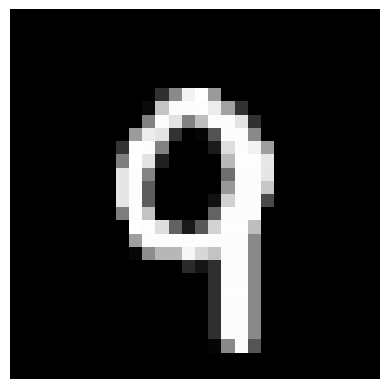

Label 9


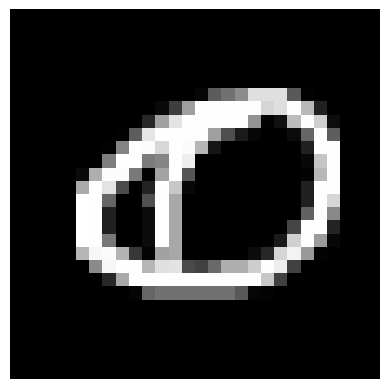

Label 0


In [ ]:
## Define a function that displays a digit given its vector representation
def show_digit(x):
    plt.axis('off')
    plt.imshow(x.reshape((28,28)), cmap=plt.cm.gray)
    plt.show()
    return

## Define a function that takes an index into a particular data set ("train" or "test") and displays that image.
def vis_image(index, dataset="train"):
    if(dataset=="train"):
        show_digit(train_data[index,])
        label = train_labels[index]
    else:
        show_digit(test_data[index,])
        label = test_labels[index]
    print("Label " + str(label))
    return

## View the first data point in the training set
vis_image(0, "train")

## Now view the first data point in the test set
vis_image(0, "test")

## 3. Squared Euclidean distance

To compute nearest neighbors in our data set, we need to first be able to compute distances between data points. A natural distance function is _Euclidean distance_: for two vectors $x, y \in \mathbb{R}^d$, their Euclidean distance is defined as
$$\|x - y\| = \sqrt{\sum_{i=1}^d (x_i - y_i)^2}.$$
Often we omit the square root, and simply compute _squared Euclidean distance_:
$$\|x - y\|^2 = \sum_{i=1}^d (x_i - y_i)^2.$$
For the purposes of nearest neighbor computations, the two are equivalent: for three vectors $x, y, z \in \mathbb{R}^d$, we have $\|x - y\| \leq \|x - z\|$ if and only if $\|x - y\|^2 \leq \|x - z\|^2$.

Now we just need to be able to compute squared Euclidean distance. The following function does so.

In [9]:
## Computes squared Euclidean distance between two vectors.
def squared_dist(x,y):
    return np.sum(np.square(x-y))

## Compute distance between a seven and a one in our training set.
print("Distance from 7 to 1: ", squared_dist(train_data[4,],train_data[5,]))

## Compute distance between a seven and a two in our training set.
print("Distance from 7 to 2: ", squared_dist(train_data[4,],train_data[1,]))

## Compute distance between two seven's in our training set.
print("Distance from 7 to 7: ", squared_dist(train_data[4,],train_data[7,]))

Distance from 7 to 1:  5357193.0
[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0

## 4. Computing nearest neighbors

Now that we have a distance function defined, we can now turn to nearest neighbor classification.

In [ ]:
## Takes a vector x and returns the index of its nearest neighbor in train_data
def find_NN(x):
    # Compute distances from x to every row in train_data
    distances = [squared_dist(x,train_data[i,]) for i in range(len(train_labels))]
    # Get the index of the smallest distance
    return np.argmin(distances)

## Takes a vector x and returns the class of its nearest neighbor in train_data
def NN_classifier(x):
    # Get the index of the the nearest neighbor
    index = find_NN(x)
    # Return its class
    return train_labels[index]

A success case:
NN classification:  0
True label:  0
The test image:


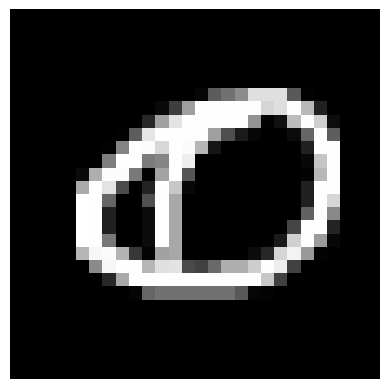

Label 0
The corresponding nearest neighbor image:


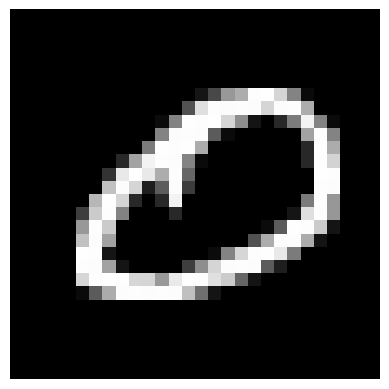

Label 0


In [ ]:
## A success case:
print("A success case:")
print("NN classification: ", NN_classifier(test_data[0,]))
print("True label: ", test_labels[0])
print("The test image:")
vis_image(0, "test")
print("The corresponding nearest neighbor image:")
vis_image(find_NN(test_data[0,]), "train")

A failure case:
NN classification:  2
True label:  3
The test image:


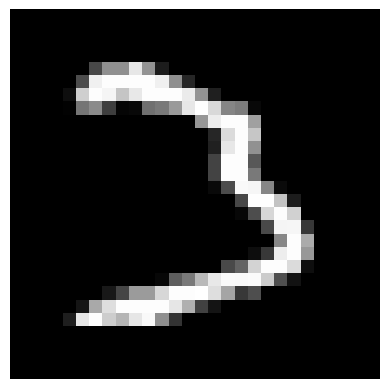

Label 3
The corresponding nearest neighbor image:


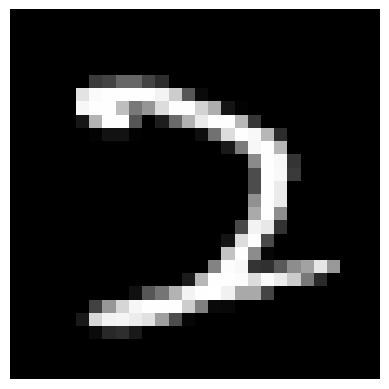

Label 2


In [ ]:
## A failure case:
print("A failure case:")
print("NN classification: ", NN_classifier(test_data[39,]))
print("True label: ", test_labels[39])
print("The test image:")
vis_image(39, "test")
print("The corresponding nearest neighbor image:")
vis_image(find_NN(test_data[39,]), "train")

## 5. For you to try
The above two examples show the results of the NN classifier on test points number 0 and 39.

Now try test point number 100.
* What is the index of its nearest neighbor in the training set? _Record the answer: you will enter it as part of this week's assignment._
* Display both the test point and its nearest neighbor.
* What label is predicted? Is this the correct label?

The Index of the nearest neighbor in the training set:  4711
The test point image:


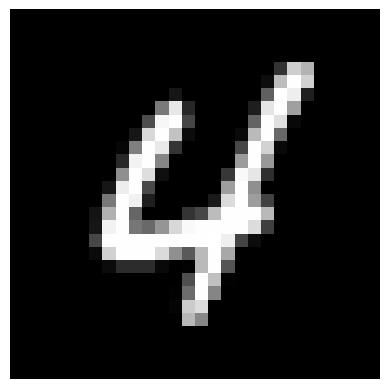

Label 4
The nearest neighbor image:


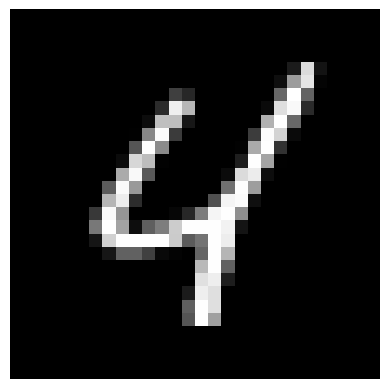

Label 4
Label predicted:  4
Its the correct Label?
Yes, it is


In [ ]:
index_nearest_neighbor = find_NN(test_data[100,])
print("The Index of the nearest neighbor in the training set: ", index_nearest_neighbor)
print("The test point image:")
vis_image(100, "test")
print("The nearest neighbor image:")
vis_image(find_NN(test_data[100,]), "train")

print("Label predicted: ", train_labels[index_nearest_neighbor])

print("Its the correct Label?")
print("Yes, it is" if test_labels[100] == train_labels[index_nearest_neighbor] else "No, its not")

## 6. Processing the full test set

Now let's apply our nearest neighbor classifier over the full data set.

Note that to classify each test point, our code takes a full pass over each of the 7500 training examples. Thus we should not expect testing to be very fast. The following code takes about 100-150 seconds on 2.6 GHz Intel Core i5.

In [ ]:
## Predict on each test data point (and time it!)
t_before = time.time()
test_predictions = [NN_classifier(test_data[i,]) for i in range(len(test_labels))]
t_after = time.time()

## Compute the error
err_positions = np.not_equal(test_predictions, test_labels)
error = float(np.sum(err_positions))/len(test_labels)

print("Error of nearest neighbor classifier: ", error)
print("Classification time (seconds): ", t_after - t_before)

Error of nearest neighbor classifier:  0.046
Classification time (seconds):  59.897881269454956


## 7. Faster nearest neighbor methods

Performing nearest neighbor classification in the way we have presented requires a full pass through the training set in order to classify a single point. If there are $N$ training points in $\mathbb{R}^d$, this takes $O(N d)$ time.

Fortunately, there are faster methods to perform nearest neighbor look up if we are willing to spend some time preprocessing the training set. `scikit-learn` has fast implementations of two useful nearest neighbor data structures: the _ball tree_ and the _k-d tree_.

In [ ]:
from sklearn.neighbors import BallTree

## Build nearest neighbor structure on training data
t_before = time.time()
ball_tree = BallTree(train_data)
t_after = time.time()

## Compute training time
t_training = t_after - t_before
print("Time to build data structure (seconds): ", t_training)

## Get nearest neighbor predictions on testing data
t_before = time.time()
test_neighbors = np.squeeze(ball_tree.query(test_data, k=1, return_distance=False))
ball_tree_predictions = train_labels[test_neighbors]
t_after = time.time()

## Compute testing time
t_testing = t_after - t_before
print("Time to classify test set (seconds): ", t_testing)

## Verify that the predictions are the same
print("Ball tree produces same predictions as above? ", np.array_equal(test_predictions, ball_tree_predictions))

Time to build data structure (seconds):  0.47275805473327637
Time to classify test set (seconds):  11.27992033958435
Ball tree produces same predictions as above?  True


In [ ]:
from sklearn.neighbors import KDTree

## Build nearest neighbor structure on training data
t_before = time.time()
kd_tree = KDTree(train_data)
t_after = time.time()

## Compute training time
t_training = t_after - t_before
print("Time to build data structure (seconds): ", t_training)

## Get nearest neighbor predictions on testing data
t_before = time.time()
test_neighbors = np.squeeze(kd_tree.query(test_data, k=1, return_distance=False))
kd_tree_predictions = train_labels[test_neighbors]
t_after = time.time()

## Compute testing time
t_testing = t_after - t_before
print("Time to classify test set (seconds): ", t_testing)

## Verify that the predictions are the same
print("KD tree produces same predictions as above? ", np.array_equal(test_predictions, kd_tree_predictions))

Time to build data structure (seconds):  0.7116649150848389
Time to classify test set (seconds):  13.612921714782715
KD tree produces same predictions as above?  True
